In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

PATH = "/content/drive/MyDrive/islemler_final.csv"

df = pd.read_csv(
    PATH,
    sep=";",              # TR Excel çoğunlukla ; kullanır
    encoding="utf-8-sig",
    decimal=",",          # ondalık virgül olasılığı
    low_memory=False
)

df.head()


,islem_id,kullanici_id,tarih,saat,tutar,islem_kategorisi,odeme_yontemi,cihaz_tipi,sehir,banka_tipi,ayni_gun_islem_sayisi,son_30dk_islem_sayisi,daha_once_reddedildi_mi,fraud
0,1.0,1.0,2025-12-11,15:00:04,1500.0,para_transferi,banka_transferi,atm,manisa,akbank,1.0,0.0,0.0,0
1,2.0,2.0,2025-12-11,14:10:29,62.5,alisveris,banka_karti,pos,manisa,ziraat,4.0,0.0,0.0,0
2,3.0,2.0,2025-12-11,16:04:09,6000.0,burs,banka_transferi,sistem,manisa,ziraat,4.0,0.0,0.0,0
3,4.0,2.0,2025-12-11,17:19:54,100.0,para_transferi,banka_transferi,mobil,manisa,ziraat,4.0,0.0,0.0,0
4,5.0,2.0,2025-12-11,20:49:45,94.0,alisveris,banka_karti,pos,manisa,ziraat,4.0,0.0,0.0,0


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   islem_id                 600 non-null    float64
 1   kullanici_id             600 non-null    float64
 2   tarih                    600 non-null    object 
 3   saat                     600 non-null    object 
 4   tutar                    597 non-null    float64
 5   islem_kategorisi         600 non-null    object 
 6   odeme_yontemi            600 non-null    object 
 7   cihaz_tipi               600 non-null    object 
 8   sehir                    600 non-null    object 
 9   banka_tipi               600 non-null    object 
 10  ayni_gun_islem_sayisi    600 non-null    float64
 11  son_30dk_islem_sayisi    600 non-null    float64
 12  daha_once_reddedildi_mi  600 non-null    float64
 13  fraud                    600 non-null    int64  
dtypes: float64(6), int64(1), o

In [4]:
import pandas as pd

# Güvenli kopya
df_clean = df.copy()

# 1) ID alanlarını int yap
id_cols = ["islem_id", "kullanici_id"]
for col in id_cols:
    df_clean[col] = df_clean[col].astype(int)

# 2) tarih + saat -> datetime
df_clean["tarih"] = pd.to_datetime(df_clean["tarih"], errors="coerce")

df_clean["datetime"] = pd.to_datetime(
    df_clean["tarih"].dt.strftime("%Y-%m-%d") + " " + df_clean["saat"],
    errors="coerce"
)

# Saat feature'ı çıkar
df_clean["hour"] = df_clean["datetime"].dt.hour

# 3) tutar eksik değerleri doldur (median = en güvenlisi)
df_clean["tutar"] = df_clean["tutar"].fillna(df_clean["tutar"].median())

# 4) binary alanları int yap
binary_cols = [
    "ayni_gun_islem_sayisi",
    "son_30dk_islem_sayisi",
    "daha_once_reddedildi_mi",
    "fraud"
]
for col in binary_cols:
    df_clean[col] = df_clean[col].astype(int)

# Kontrol
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   islem_id                 600 non-null    int64         
 1   kullanici_id             600 non-null    int64         
 2   tarih                    600 non-null    datetime64[ns]
 3   saat                     600 non-null    object        
 4   tutar                    600 non-null    float64       
 5   islem_kategorisi         600 non-null    object        
 6   odeme_yontemi            600 non-null    object        
 7   cihaz_tipi               600 non-null    object        
 8   sehir                    600 non-null    object        
 9   banka_tipi               600 non-null    object        
 10  ayni_gun_islem_sayisi    600 non-null    int64         
 11  son_30dk_islem_sayisi    600 non-null    int64         
 12  daha_once_reddedildi_mi  600 non-nul

In [5]:
# hour null olanları median saat ile doldur
median_hour = df_clean["hour"].median()

df_clean["hour"] = df_clean["hour"].fillna(median_hour)

# datetime null olanları tarih + hour ile yeniden oluştur
df_clean["datetime"] = df_clean["datetime"].fillna(
    df_clean["tarih"] + pd.to_timedelta(df_clean["hour"], unit="h")
)

# kontrol
df_clean[["datetime", "hour"]].isnull().sum()


,0
datetime,0
hour,0


In [6]:
df_clean.shape


(600, 16)

In [7]:
df_clean.columns


Index(['islem_id', 'kullanici_id', 'tarih', 'saat', 'tutar',
       'islem_kategorisi', 'odeme_yontemi', 'cihaz_tipi', 'sehir',
       'banka_tipi', 'ayni_gun_islem_sayisi', 'son_30dk_islem_sayisi',
       'daha_once_reddedildi_mi', 'fraud', 'datetime', 'hour'],
      dtype='object')

In [8]:
df_clean.dtypes


,0
islem_id,int64
kullanici_id,int64
tarih,datetime64[ns]
saat,object
tutar,float64
islem_kategorisi,object
odeme_yontemi,object
cihaz_tipi,object
sehir,object
banka_tipi,object


In [9]:
df_clean.isnull().sum()


,0
islem_id,0
kullanici_id,0
tarih,0
saat,0
tutar,0
islem_kategorisi,0
odeme_yontemi,0
cihaz_tipi,0
sehir,0
banka_tipi,0


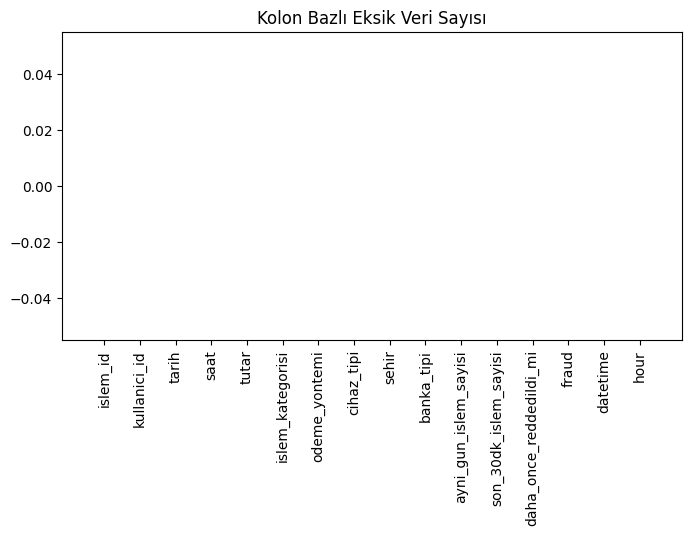

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(df_clean.columns, df_clean.isnull().sum())
plt.xticks(rotation=90)
plt.title("Kolon Bazlı Eksik Veri Sayısı")
plt.show()


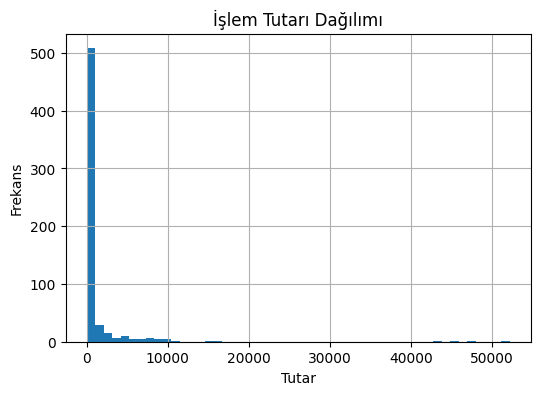

In [11]:
plt.figure(figsize=(6,4))
df_clean["tutar"].hist(bins=50)
plt.title("İşlem Tutarı Dağılımı")
plt.xlabel("Tutar")
plt.ylabel("Frekans")
plt.show()


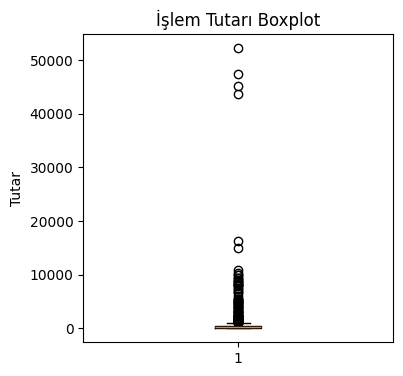

In [12]:
plt.figure(figsize=(4,4))
plt.boxplot(df_clean["tutar"])
plt.title("İşlem Tutarı Boxplot")
plt.ylabel("Tutar")
plt.show()


In [13]:
q1 = df_clean["tutar"].quantile(0.25)
q3 = df_clean["tutar"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df_clean[(df_clean["tutar"] < lower) | (df_clean["tutar"] > upper)].shape


(93, 16)

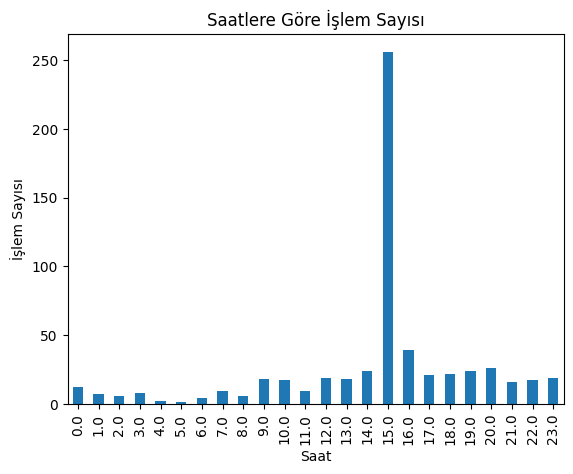

In [14]:
df_clean["hour"].value_counts().sort_index().plot(kind="bar")
plt.title("Saatlere Göre İşlem Sayısı")
plt.xlabel("Saat")
plt.ylabel("İşlem Sayısı")
plt.show()


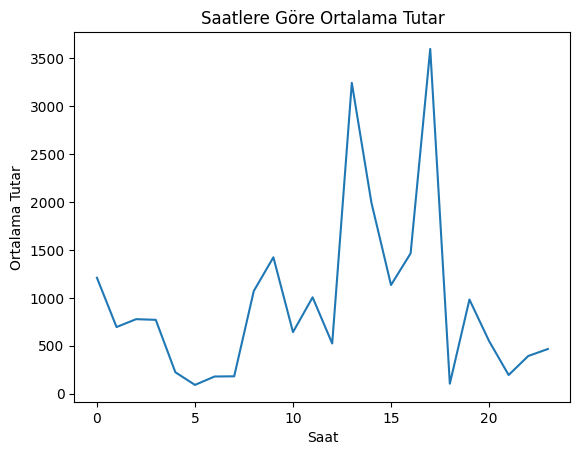

In [15]:
df_clean.groupby("hour")["tutar"].mean().plot()
plt.title("Saatlere Göre Ortalama Tutar")
plt.xlabel("Saat")
plt.ylabel("Ortalama Tutar")
plt.show()


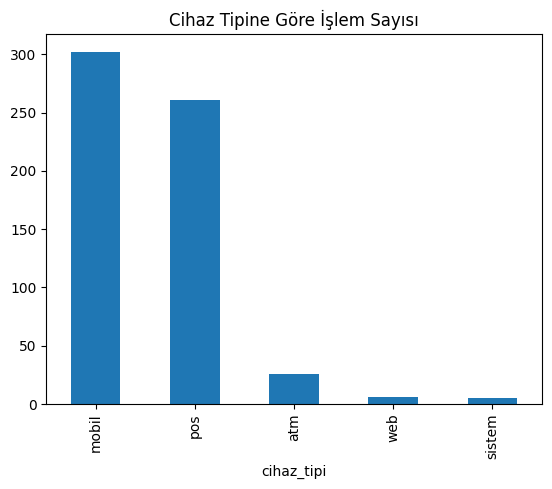

In [16]:
df_clean["cihaz_tipi"].value_counts().plot(kind="bar")
plt.title("Cihaz Tipine Göre İşlem Sayısı")
plt.show()


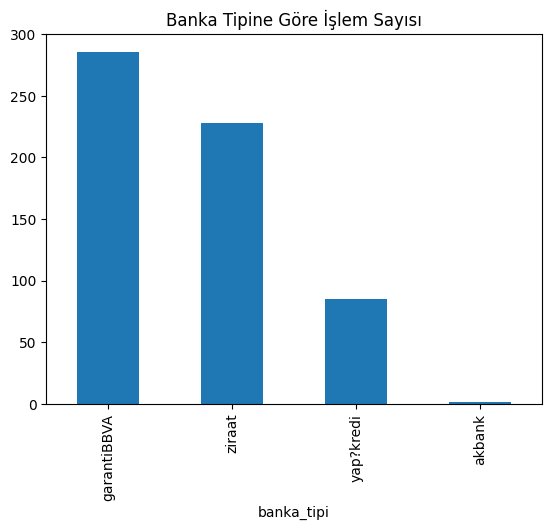

In [17]:
df_clean["banka_tipi"].value_counts().plot(kind="bar")
plt.title("Banka Tipine Göre İşlem Sayısı")
plt.show()


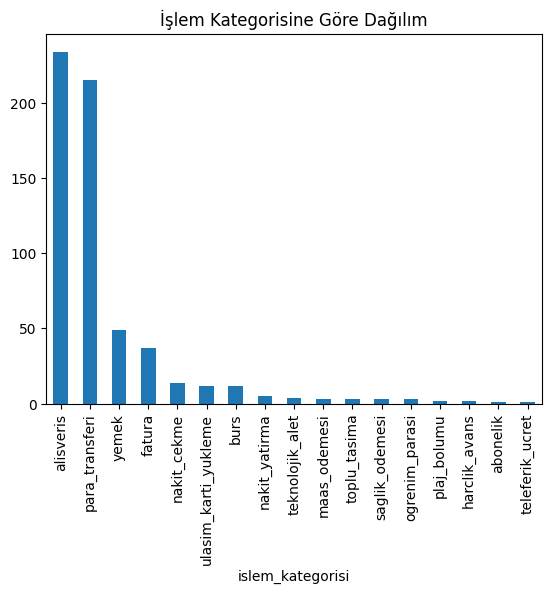

In [18]:
df_clean["islem_kategorisi"].value_counts().plot(kind="bar")
plt.title("İşlem Kategorisine Göre Dağılım")
plt.show()


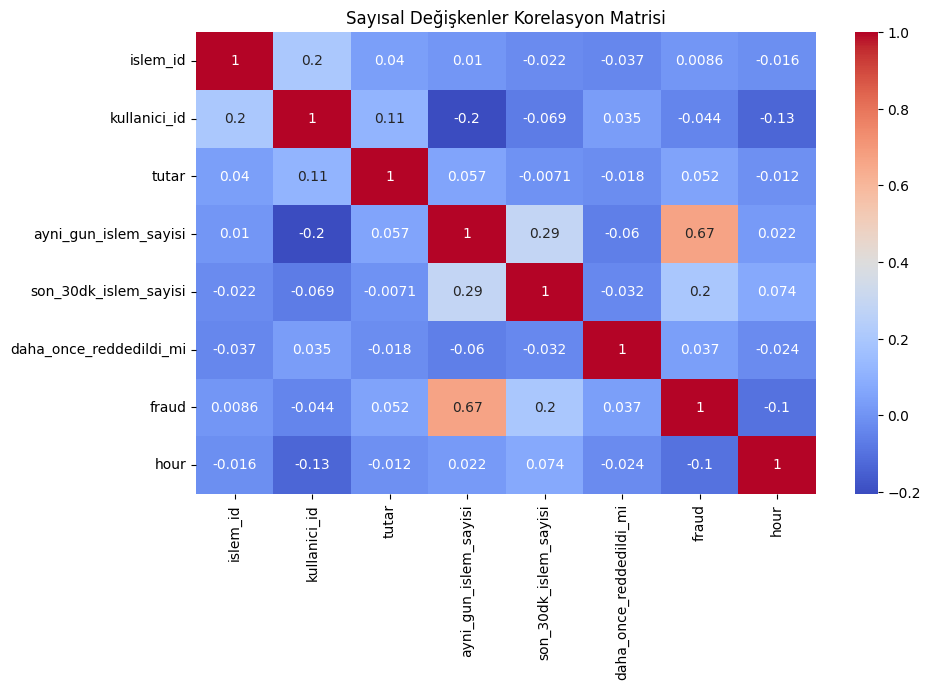

In [19]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df_clean.select_dtypes(include=["int64","float64"]).corr(), annot=True, cmap="coolwarm")
plt.title("Sayısal Değişkenler Korelasyon Matrisi")
plt.show()


In [20]:
X = df_clean.drop(columns=["fraud", "datetime", "tarih", "saat"])
y = df_clean["fraud"]


In [21]:
X = pd.get_dummies(X, drop_first=True)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Sonuçları")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Sonuçları
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       128
           1       0.86      0.82      0.84        22

    accuracy                           0.95       150
   macro avg       0.91      0.90      0.90       150
weighted avg       0.95      0.95      0.95       150



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Sonuçları")
print(classification_report(y_test, y_pred_rf))


Random Forest Sonuçları
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       128
           1       1.00      0.91      0.95        22

    accuracy                           0.99       150
   macro avg       0.99      0.95      0.97       150
weighted avg       0.99      0.99      0.99       150



In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Sonuçları")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Sonuçları
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       128
           1       1.00      0.95      0.98        22

    accuracy                           0.99       150
   macro avg       1.00      0.98      0.99       150
weighted avg       0.99      0.99      0.99       150



In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

comparison = pd.DataFrame({
    "Logistic Regression": get_metrics(y_test, y_pred_lr),
    "Random Forest": get_metrics(y_test, y_pred_rf),
    "Gradient Boosting": get_metrics(y_test, y_pred_gb)
})

comparison


,Logistic Regression,Random Forest,Gradient Boosting
Accuracy,0.953333,0.986667,0.993333
Precision,0.857143,1.000000,1.000000
Recall,0.818182,0.909091,0.954545
F1,0.837209,0.952381,0.976744


In [27]:
import joblib

joblib.dump(gb, "/content/drive/MyDrive/4LU_PROJE/fraud_model.joblib")
print("Nihai model (Gradient Boosting) kaydedildi.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/4LU_PROJE/fraud_model.joblib'

In [28]:
import os

os.makedirs("/content/drive/MyDrive/4LU_PROJE", exist_ok=True)


In [29]:
import joblib

joblib.dump(gb, "/content/drive/MyDrive/4LU_PROJE/fraud_model.joblib")
print("Nihai model (Gradient Boosting) kaydedildi.")


Nihai model (Gradient Boosting) kaydedildi.
